In [42]:

import torch
import torch.cuda
import torch.nn as nn
#%pip install torchvision
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
#%pip install einops
import einops
import matplotlib.pyplot as plt
import numpy as np
import math
#from torch.utils.tensorboard import SummaryWriter


## Le bon format

### 1. Récupérer une image du Dataset ou Dataloader et affichez la.

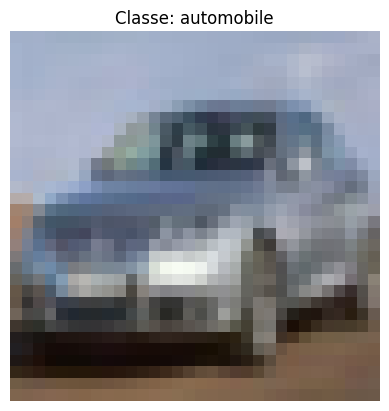

In [43]:
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
index = np.random.randint(len(trainset))
image, label = trainset[index]

image = image.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f"Classe: {trainset.classes[label]}")
plt.axis("off")
plt.show()

### 2. Calculer le nombre de patch nécessaire

In [44]:
height = 32
width = 32
color_channels = 3
patch_size = 4 #votre valeur

#Calcul du nombre de patchs
number_of_patches = (height * width) // (patch_size**2)
print(number_of_patches)

64


### 3. Utiliser une convolution pour générer des patchs

In [45]:
dim_in = color_channels
dim_out = patch_size**2
patchenizer = nn.Conv2d(dim_in,dim_out,kernel_size=patch_size,stride=patch_size)

### 4.1 Créer un objet pour réaliser les patchs.

In [46]:
class Patch(nn.Module):
    def __init__(self, dim_in, dim_out, patch_size):
        super(Patch, self).__init__()
        self.conv = nn.Conv2d(dim_in, dim_out, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        x = self.conv(x)
        #print(f"Après convolution: {x.shape}")  # Debug
        x = x.flatten(2)
        #print(f"Après flatten: {x.shape}")  # Debug
        x = x.permute(0, 2, 1)
        #print(f"Après permute: {x.shape}")  # Debug
        return x.squeeze(0)



### 4.2 Test des dimensions de l'objet

In [47]:
model = Patch(dim_in,dim_out,patch_size)
image, label = next(iter(trainset))
image = image.unsqueeze(0)
print(image.shape)
res = model(image)
print(res.shape)

torch.Size([1, 3, 32, 32])
torch.Size([64, 16])


## Scaled Dot Product Attention

### Calcul de l'attention via SoftMax

In [48]:
def scaled_dot_product(q, k, v):
        d_k = q.size()[-1]
        attn_logits = torch.matmul(q,torch.transpose(k, -2, -1))#multiplication matricielle entre q et k
        attn_logits = attn_logits/math.sqrt(d_k)#scaling avec d_k (voir equation)
        attention = torch.softmax(attn_logits,dim=-1)#faire le softmax sur la dernière dimension
        values = torch.matmul(attention,v)#multiplication matricielle avec v
        return values

### Test du scaled_dot_product

In [49]:
seq_len, d_k = 3, 2
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values = scaled_dot_product(q, k, v)
print("Q\n", q.shape)
print("K\n", k.shape)
print("V\n", v.shape)
print("Values\n", values.shape)

Q
 torch.Size([3, 2])
K
 torch.Size([3, 2])
V
 torch.Size([3, 2])
Values
 torch.Size([3, 2])


### Définition de la classe qkv_proj et test avec le scaled_dot_product

In [50]:
class qkv_proj(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.proj = nn.Linear(d_in, d_out * 3)
    def forward(self, x):
        x = self.proj(x)
        #print(f"Après proj: {x.shape}")  # Debug
        return x.chunk(3, dim=-1)
    
model = qkv_proj(dim_out,dim_out)

q,k,v = model(res)
print(f"q shape: {q.shape}")  
print(f"k shape: {k.shape}")  
print(f"v shape: {v.shape}")
values = scaled_dot_product(q, k, v)
print("Q\n", q.shape)
print("K\n", k.shape)
print("V\n", v.shape)
print("Values\n", values.shape)


q shape: torch.Size([64, 16])
k shape: torch.Size([64, 16])
v shape: torch.Size([64, 16])
Q
 torch.Size([64, 16])
K
 torch.Size([64, 16])
V
 torch.Size([64, 16])
Values
 torch.Size([64, 16])


## Multi-Head Attention

### Re-Définition de la classe qkv_proj

In [51]:
class qkv_proj(nn.Module):
    def __init__(self, d_in, d_out, num_heads):
        super().__init__()
        self.num_heads = num_heads

        self.proj = nn.Linear(d_in, d_out * 3)
    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        #print(f"Batch size : {batch_size}, seq_length : {seq_length}") # Debug
        qkv = self.proj(x)
        #print(f"Après proj: {qkv.shape}")  # Debug
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, -1)
        #print(f"Après Reshape: {qkv.shape}")  # Debug
        qkv = qkv.permute(0,2,1,3) #permute Batch, Head, SeqLen, Dims
        #print(f"Après permute: {qkv.shape}")  # Debug
        return qkv.chunk(3, dim=-1)
    
q,k,v = qkv_proj(32, 32*3, 4)(torch.randn(1,64,32))
q.shape, k.shape, v.shape

(torch.Size([1, 4, 64, 24]),
 torch.Size([1, 4, 64, 24]),
 torch.Size([1, 4, 64, 24]))

### Définition de la classe MultiheadAttention

In [52]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        #ps: juste pour vérifier que votre dimension
        #   match bien le nombre de tête...
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads

        #in_proj - votre fonction qkv_proj créé précédement
        self.in_proj = qkv_proj(input_dim, embed_dim, num_heads)
        
        self.o_proj = nn.Linear(embed_dim, embed_dim)
    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        q, k, v = self.in_proj(x)
        #print(f"Avant scale: {q.shape} {k.shape} {v.shape} ")  # Debug
        #appeler votre fonction scaled_dot_product
        attn = scaled_dot_product(q, k, v)
        #print(f"Après scale: {attn.shape}")  # Debug
        #Permute back
        #Votre position de départ : [Batch, Head, SeqLen, Dims]
        
        #Permute dans la nouvelle dim : [Batch, SeqLen, Head, Dims]
        #print(f"Avant permute: {attn.shape}")  # Debug
        attn = attn.permute(0,2,1,3)
        #print(f"Après permute: {attn.shape}")  # Debug
        #reshape pour retirer la dimension "head".
        #aide : position de départ [Batch, SeqLen, Head, Dims]
        # position d'arrivée [Batch, SeqLen, self.embed_dim]
        attn = attn.reshape([batch_size,seq_length,self.embed_dim])
        out = self.o_proj(attn)

        return out

In [53]:
net = MultiheadAttention(64, 64, 4)
net(torch.randn(1,16*16,64)).shape

torch.Size([1, 256, 64])

### Définition de la classe FeedFoward

In [54]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim,hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim,dim)
        )
    def forward(self, x):
        return self.net(x)

### Définition de la classe Transformer (Optimus Prime)

In [55]:
class Transformer(nn.Module):
    def __init__(self, dim, heads, hidden_dim):
        super().__init__()
        self.multihead = MultiheadAttention(dim,dim,heads)
        self.FFoward = FeedForward(dim,hidden_dim)
    def forward(self, x):
        x = self.multihead(x)
        x = self.FFoward(x)
        return x

## Mise en place de la classe ViT

### Définition de la classe TowerViT

In [60]:
class TowerViT(nn.Module):
    def __init__(self, num_layers, dim, num_heads, hidden_dim, num_classes):
        super().__init__()
        self.embedding = Patch(3, dim, patch_size)
        self.transformer_blocks = nn.Sequential(*[Transformer(dim, num_heads, hidden_dim) for _ in range(num_layers)])
        self.mlp_head = nn.Linear(dim, num_classes)
        self.max = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_blocks(x)
        x = self.mlp_head(x)
        x = self.max(x[:,0])  # Global average pooling
        return x

### Définition de la classe ViT

In [61]:
image_size = 32
patch_size = 4
num_classes = 10
dim = 64
num_heads = 4
hidden_dim = 128
num_layers = 6
batch_size = 128
epochs = 10
learningRate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TowerViT(num_layers, dim, num_heads, hidden_dim, num_classes).to(device)
lossFn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=learningRate)   
 
def accuracy(label, res, size=128):
  res = (label==res)
  
  return res.sum()/size

def fit_one_cycle(model, train, valid, opt, lossFn, epoch):
    model.train()
    lossT = 0.0
    accT = 0.0
    
    for batch in train:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        opt.zero_grad()
        res = model(inputs)
        loss = lossFn(res,labels)
        
        loss.backward()
        opt.step()
        
        lossT += loss.item()
        _, index= torch.max(res, dim=1)
        accT += accuracy(labels, index)
        
        opt.zero_grad()
    
    lossT /= len(train)
    accT /= len(train)
    
    model.eval()
    lossV = 0.0
    accV = 0.0
    
    with torch.no_grad():
        for batch in valid:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            res = model(inputs)
            loss = lossFn(res,labels)
            
            lossV += loss.item()
            _, index= torch.max(res, dim=1)
            accV += accuracy(labels, index)
        
        
    lossV /= len(valid)
    accV /= len(valid)
    print(f"Epoch {epoch+1}: Train Loss: {lossT:.4f}, Train Acc: {accT:.4f}, Val Loss: {lossV:.4f}, Val Acc: {accV:.4f}")


trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
valset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
train = torch.utils.data.DataLoader(trainset,
                                    batch_size=128, 
                                    shuffle=True
                                )
valid = torch.utils.data.DataLoader(valset,
                                    batch_size=128, 
                                    shuffle=False
                                )

epoch = 10

for i in range(epoch):
    fit_one_cycle(model, train, valid, opt, lossFn, i)


Using device: cpu
Epoch 1: Train Loss: 2.3027, Train Acc: 0.0984, Val Loss: 2.3026, Val Acc: 0.0989
Epoch 2: Train Loss: 2.3027, Train Acc: 0.0999, Val Loss: 2.3026, Val Acc: 0.0989
Epoch 3: Train Loss: 2.3026, Train Acc: 0.0967, Val Loss: 2.3026, Val Acc: 0.0989
Epoch 4: Train Loss: 2.3026, Train Acc: 0.0978, Val Loss: 2.3026, Val Acc: 0.0989
Epoch 5: Train Loss: 2.3026, Train Acc: 0.0970, Val Loss: 2.3026, Val Acc: 0.0989
Epoch 6: Train Loss: 2.3026, Train Acc: 0.0980, Val Loss: 2.3026, Val Acc: 0.0989
Epoch 7: Train Loss: 2.3026, Train Acc: 0.0968, Val Loss: 2.3026, Val Acc: 0.0989
Epoch 8: Train Loss: 2.3026, Train Acc: 0.0984, Val Loss: 2.3026, Val Acc: 0.0989
Epoch 9: Train Loss: 2.3026, Train Acc: 0.0975, Val Loss: 2.3026, Val Acc: 0.0989
Epoch 10: Train Loss: 2.3029, Train Acc: 0.0977, Val Loss: 2.3026, Val Acc: 0.0989
